# The problem

Let $\Omega =  (-1,1)\times (-1,1)$, the problem is

---

$$
\begin{cases}
|Du(x,y)|= 1 + \epsilon \Delta (x,y), & \qquad\text{for}\; (x,y)\in (-1,1)\times (-1,1),\\
u(x,y) = 1 - \sqrt{x^2+y^2} , &\qquad\text{for}\; (x,y)\in \partial \Omega
\end{cases}
$$ 

---

The exact solution is 

---

$$u(x,y) = 1 - \sqrt{x^2+y^2}$$

---

The Loss is

$$ L(\hat{u}) = \frac{1}{N^2}\sum_{j=1}^N\sum_{i=1}^N \Big(|D\hat{u}(x_i,y_j)|-1 - ϵ\Delta(x_i,y_j)\Big)^2$$

# Loading libraries

In [1]:
# Import libraries
import numpy as np
import math
from numpy import linalg
import pandas as pd
# !pip3 install torch==1.2.0+cu92 torchvision==0.4.0+cu92 -f https://download.pytorch.org/whl/torch_stable.html
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import torch.nn.init as init
from torch import autograd

from torch import nn, optim
from time import time

In [2]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
def draw_loss(iter, loss, title='Loss'):
    plt.plot(iter, loss, '-b', label='loss')
    plt.xlabel("n iteration")
    plt.legend(loc='upper left')
    plt.title(title)
    # save image
    plt.savefig(title +".png")  # should before show method
    # show
    plt.show()

def draw_graph(lst_iter, lst_loss, lst_acc, title):
    plt.plot(lst_iter, lst_loss, '-b', label='true')
    plt.plot(lst_iter, lst_acc, '-r', label='neural network')
    plt.xlabel("x")
    plt.legend(loc='upper left')
    plt.title(title)
    plt.axis('off')
    
    # save image
    plt.savefig(title+".png")  # should before show method
    # show
    plt.show()

from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    "Helper function for saving GIFs"
    "Credit: Ben Moseley"
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], 
                 save_all=True, duration=int(1000/fps), loop=loop)

def graph(x, y, u_hat):
    X = x.detach().numpy()
    Y = y.detach().numpy()
    Z = u_hat.detach().numpy()
    true_sol = 1-np.sqrt(X**2 + Y**2)
    print('MSE between the true solution and NN sol:', np.mean((Z-true_sol)**2))
    fig = plt.figure(figsize=plt.figaspect(0.5))
    ax = fig.add_subplot(1, 3, 1, projection='3d')

    ax.plot_surface(X, Y, Z,  
                    rstride=1, cstride=1,
                    cmap='winter', edgecolor='none')
    ax.title.set_text('neural network')
    # ax.set_zlim([-.5,.5])

    ax = fig.add_subplot(1, 3, 2, projection='3d')  
    ax.plot_surface(X, Y, true_sol,  
                    rstride=1, cstride=1,
                    cmap='autumn', edgecolor='none')     
    ax.title.set_text('true solution')
    # ax.set_zlim([-.5,.5])

    # ax = fig.add_subplot(1, 3, 3, projection='3d')  
    # ax.plot_surface(X, Y, Z,  
    #                 rstride=1, cstride=1,
    #                 cmap='winter', edgecolor='none')
    # ax.plot_surface(X, Y, true_sol,  
    #                 rstride=1, cstride=1,
    #                 cmap='autumn', edgecolor='none')    
    # ax.set_zlim([-.5,.5])

    # ax.title.set_text('joint plot')           

In [3]:
N = 32
xs = torch.linspace(-1, 1, steps=N, requires_grad=True)
ys = torch.linspace(-1, 1, steps=N, requires_grad=True)
x, y = torch.meshgrid(xs, ys, indexing='xy')
[step_x, step_y] = [2/(N-1),2/(N-1)]

# Gradient functions

In [4]:
def gradient(u, step_x, step_y):
    # all inputs are (n*n)-dim pytorch tensor
    [Nx, Ny] = list(u.size())
    u_x_tensor = 0*u.clone()
    for row in range(1, Ny-1):
        u_x_tensor[row, 1:-1] = (-u[row, 0:-2] + u[row, 2:])/(2*step_x)
    u_y_tensor = 0*u.clone()
    for col in range(1, Nx-1):
        u_y_tensor[1:-1, col] = (-u[0:-2, col] + u[2:, col])/(2*step_y)
    return [u_x_tensor, u_y_tensor]    

def abs_grad(u, step_x, step_y):
    [u_x, u_y] = gradient(u, step_x, step_y)
    return torch.sqrt(torch.square(u_x) + torch.square(u_y))

def Laplacian(u, step_x, step_y):
    [Nx, Ny] = list(u.size())
    u_xx = 0*u.clone()
    for row in range(1, Ny-1):
        u_xx[row, 1:-1] = (u[row, 0:-2] + u[row, 2:] - 2*u[row, 1:-1])/(step_x**2)
    u_yy = 0*u.clone()
    for col in range(1, Nx-1):
        u_yy[1:-1, col] = (u[0:-2, col] + u[2:, col] - 2*u[1:-1, col])/(step_y**2)
    return (u_xx + u_yy)

# Model

In [5]:
def PDEsNet(input_size=2, output_size=1, k=32):
    model = nn.Sequential(
        nn.Linear(input_size, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),
        nn.Linear(k, k),
        nn.Tanh(),        
        nn.Linear(k, output_size),
        nn.Tanh(),
                      )
    return model
# module5 = nn.Linear(hidden_sizes[3], hidden_sizes[4])
# init.xavier_normal_(module5.weight)

# Pack and Unpack

In [6]:
def unpack_column(xs, ys, Nx, Ny):
    x, y = torch.meshgrid(xs, ys, indexing='xy')
    # unpack_col = []
    for i in range(0, Nx):
        row_i = torch.stack([x[:,i],y[:,i]], dim=1)
        if i == 0:
            unpack_col = row_i
        else:    
            unpack_col = torch.vstack([unpack_col,row_i])
    return unpack_col        

In [7]:
def pack_column(u, Nx, Ny):
    return torch.transpose(u.reshape((Nx, Ny)), 0, 1)

# Training

In [8]:
[Nx, Ny] = [len(x), len(y)]
torch.manual_seed(111)
model = PDEsNet(input_size=2, output_size=1, k=64)
files = []

In [9]:
def Loss(u_hat, xs, ys, eps, step_x, step_y):  
    [Nx, Ny] = list(u_hat.size())
    # all inputs are (n*n)-dim pytorch tensor
    Delta_u = Laplacian(u_hat, step_x, step_y)
    loss = nn.MSELoss()
    one_tensor = torch.ones(Nx, Ny, dtype=torch.float32)
    [u_x, u_y] = gradient(u_hat, step_x, step_y)
    Du2 = u_x**2 + u_y**2
    result = loss(Du2[1:-1,1:-1] - eps*Delta_u[1:-1,1:-1], one_tensor[1:-1, 1:-1]) 
    return result

The running loss at 009 iteration is: 1.0940157175064087
MSE between the true solution and NN sol: 0.24073693
The running loss at 019 iteration is: 1.0649789571762085
MSE between the true solution and NN sol: 0.24883585
The running loss at 029 iteration is: 1.0614628791809082
MSE between the true solution and NN sol: 0.23587824
The running loss at 039 iteration is: 1.0577069520950317
MSE between the true solution and NN sol: 0.24395981
The running loss at 049 iteration is: 1.0550223588943481
MSE between the true solution and NN sol: 0.23809478
The running loss at 059 iteration is: 1.0537769794464111
MSE between the true solution and NN sol: 0.24197851
The running loss at 069 iteration is: 1.0520811080932617
MSE between the true solution and NN sol: 0.23704131
The running loss at 079 iteration is: 1.050292730331421
MSE between the true solution and NN sol: 0.23921163
The running loss at 089 iteration is: 1.0481648445129395
MSE between the true solution and NN sol: 0.2362315
The running 

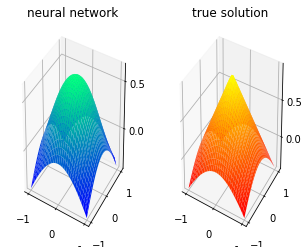

The running loss at 509 iteration is: 0.14193809032440186
MSE between the true solution and NN sol: 0.0026612254
The running loss at 519 iteration is: 0.14037226140499115
MSE between the true solution and NN sol: 0.002592532
The running loss at 529 iteration is: 0.13882485032081604
MSE between the true solution and NN sol: 0.0025239876
The running loss at 539 iteration is: 0.13730551302433014
MSE between the true solution and NN sol: 0.002455967
The running loss at 549 iteration is: 0.13582420349121094
MSE between the true solution and NN sol: 0.0023888694
The running loss at 559 iteration is: 0.13438990712165833
MSE between the true solution and NN sol: 0.0023230975
The running loss at 569 iteration is: 0.13301098346710205
MSE between the true solution and NN sol: 0.0022590656
The running loss at 579 iteration is: 0.13169385492801666
MSE between the true solution and NN sol: 0.002197165
The running loss at 589 iteration is: 0.1304432600736618
MSE between the true solution and NN sol: 

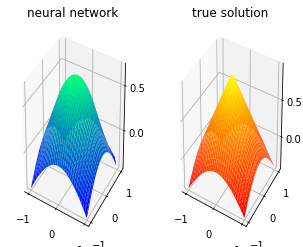

The running loss at 1009 iteration is: 0.11357922106981277
MSE between the true solution and NN sol: 0.0013658102
The running loss at 1019 iteration is: 0.11245815455913544
MSE between the true solution and NN sol: 0.0013454023
The running loss at 1029 iteration is: 0.1113661602139473
MSE between the true solution and NN sol: 0.0013180608
The running loss at 1039 iteration is: 0.11035114526748657
MSE between the true solution and NN sol: 0.0012722391
The running loss at 1049 iteration is: 0.10936301201581955
MSE between the true solution and NN sol: 0.0012466235
The running loss at 1059 iteration is: 0.10839464515447617
MSE between the true solution and NN sol: 0.0012136692
The running loss at 1069 iteration is: 0.1074419766664505
MSE between the true solution and NN sol: 0.0011866861
The running loss at 1079 iteration is: 0.10649757087230682
MSE between the true solution and NN sol: 0.0011610261
The running loss at 1089 iteration is: 0.10555635392665863
MSE between the true solution a

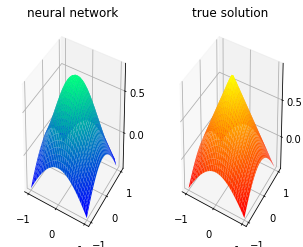

The running loss at 1509 iteration is: 0.06027205288410187
MSE between the true solution and NN sol: 0.00053878943
The running loss at 1519 iteration is: 0.05935541167855263
MSE between the true solution and NN sol: 0.0005322413
The running loss at 1529 iteration is: 0.05846380442380905
MSE between the true solution and NN sol: 0.0005259343
The running loss at 1539 iteration is: 0.057596854865550995
MSE between the true solution and NN sol: 0.0005198308
The running loss at 1549 iteration is: 0.05675383284687996
MSE between the true solution and NN sol: 0.0005138913
The running loss at 1559 iteration is: 0.055933840572834015
MSE between the true solution and NN sol: 0.0005080776
The running loss at 1569 iteration is: 0.055135853588581085
MSE between the true solution and NN sol: 0.0005023503
The running loss at 1579 iteration is: 0.05435860529541969
MSE between the true solution and NN sol: 0.0004966752
The running loss at 1589 iteration is: 0.053600702434778214
MSE between the true sol

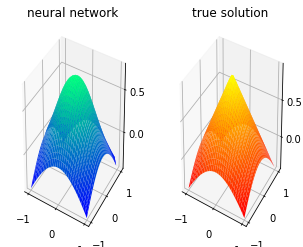

The running loss at 2009 iteration is: 0.08275534957647324
MSE between the true solution and NN sol: 0.0008121276
The running loss at 2019 iteration is: 0.07984296977519989
MSE between the true solution and NN sol: 0.0007557815
The running loss at 2029 iteration is: 0.07722633332014084
MSE between the true solution and NN sol: 0.0007166342
The running loss at 2039 iteration is: 0.07487562298774719
MSE between the true solution and NN sol: 0.0006812592
The running loss at 2049 iteration is: 0.07273300737142563
MSE between the true solution and NN sol: 0.0006491693
The running loss at 2059 iteration is: 0.07077249139547348
MSE between the true solution and NN sol: 0.0006240547
The running loss at 2069 iteration is: 0.06897113472223282
MSE between the true solution and NN sol: 0.00060440204
The running loss at 2079 iteration is: 0.06731001287698746
MSE between the true solution and NN sol: 0.0005876548
The running loss at 2089 iteration is: 0.0657736137509346
MSE between the true solution

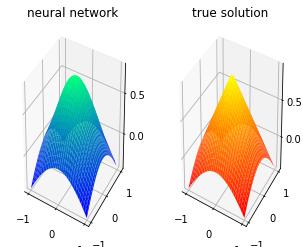

The running loss at 2509 iteration is: 0.03857237100601196
MSE between the true solution and NN sol: 0.00039206233
The running loss at 2519 iteration is: 0.038198743015527725
MSE between the true solution and NN sol: 0.00038801416
The running loss at 2529 iteration is: 0.03783023729920387
MSE between the true solution and NN sol: 0.00038398526
The running loss at 2539 iteration is: 0.037466712296009064
MSE between the true solution and NN sol: 0.0003799744
The running loss at 2549 iteration is: 0.03710807114839554
MSE between the true solution and NN sol: 0.000375981
The running loss at 2559 iteration is: 0.03675420954823494
MSE between the true solution and NN sol: 0.00037200752
The running loss at 2569 iteration is: 0.0364050567150116
MSE between the true solution and NN sol: 0.000368052
The running loss at 2579 iteration is: 0.03606046363711357
MSE between the true solution and NN sol: 0.0003641189
The running loss at 2589 iteration is: 0.03572040796279907
MSE between the true solut

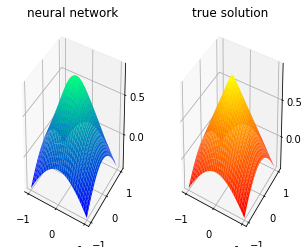

The running loss at 3009 iteration is: 0.024435976520180702
MSE between the true solution and NN sol: 0.00021107186
The running loss at 3019 iteration is: 0.02421882189810276
MSE between the true solution and NN sol: 0.00020786426
The running loss at 3029 iteration is: 0.024003632366657257
MSE between the true solution and NN sol: 0.00020467835
The running loss at 3039 iteration is: 0.023790407925844193
MSE between the true solution and NN sol: 0.0002015148
The running loss at 3049 iteration is: 0.02357918955385685
MSE between the true solution and NN sol: 0.00019837325
The running loss at 3059 iteration is: 0.023369958624243736
MSE between the true solution and NN sol: 0.00019525504
The running loss at 3069 iteration is: 0.023162759840488434
MSE between the true solution and NN sol: 0.00019216197
The running loss at 3079 iteration is: 0.02295757085084915
MSE between the true solution and NN sol: 0.00018909379
The running loss at 3089 iteration is: 0.02275446616113186
MSE between the t

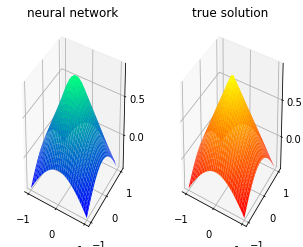

The running loss at 3509 iteration is: 0.016430910676717758
MSE between the true solution and NN sol: 9.162107e-05
The running loss at 3519 iteration is: 0.01633562333881855
MSE between the true solution and NN sol: 9.0259986e-05
The running loss at 3529 iteration is: 0.016242554411292076
MSE between the true solution and NN sol: 8.893637e-05
The running loss at 3539 iteration is: 0.016151683405041695
MSE between the true solution and NN sol: 8.764948e-05
The running loss at 3549 iteration is: 0.01606292836368084
MSE between the true solution and NN sol: 8.639942e-05
The running loss at 3559 iteration is: 0.015976250171661377
MSE between the true solution and NN sol: 8.51832e-05
The running loss at 3569 iteration is: 0.01589156687259674
MSE between the true solution and NN sol: 8.400227e-05
The running loss at 3579 iteration is: 0.0158088356256485
MSE between the true solution and NN sol: 8.285465e-05
The running loss at 3589 iteration is: 0.01572798192501068
MSE between the true solut

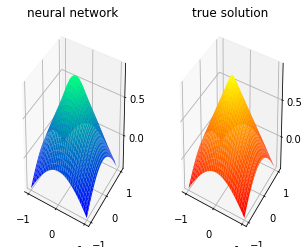

The running loss at 4009 iteration is: 0.013821329921483994
MSE between the true solution and NN sol: 6.3228115e-05
The running loss at 4019 iteration is: 0.014684544876217842
MSE between the true solution and NN sol: 7.801165e-05
The running loss at 4029 iteration is: 0.014484366402029991
MSE between the true solution and NN sol: 7.7448894e-05
The running loss at 4039 iteration is: 0.01325834821909666
MSE between the true solution and NN sol: 5.2623036e-05
The running loss at 4049 iteration is: 0.014399676583707333
MSE between the true solution and NN sol: 7.675298e-05
The running loss at 4059 iteration is: 0.01334485411643982
MSE between the true solution and NN sol: 5.6487625e-05
The running loss at 4069 iteration is: 0.013992671854794025
MSE between the true solution and NN sol: 6.8731446e-05
The running loss at 4079 iteration is: 0.013095156289637089
MSE between the true solution and NN sol: 5.3856882e-05
The running loss at 4089 iteration is: 0.014149426482617855
MSE between the 

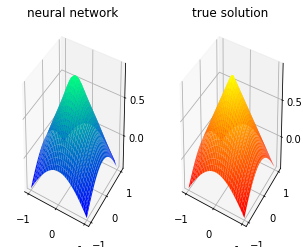

The running loss at 4509 iteration is: 0.01242912095040083
MSE between the true solution and NN sol: 6.364584e-05
The running loss at 4519 iteration is: 0.011356107890605927
MSE between the true solution and NN sol: 4.1062653e-05
The running loss at 4529 iteration is: 0.01333004329353571
MSE between the true solution and NN sol: 8.138296e-05
The running loss at 4539 iteration is: 0.011848311871290207
MSE between the true solution and NN sol: 5.4045708e-05
The running loss at 4549 iteration is: 0.011570674367249012
MSE between the true solution and NN sol: 4.6378347e-05
The running loss at 4559 iteration is: 0.013305975124239922
MSE between the true solution and NN sol: 8.25131e-05
The running loss at 4569 iteration is: 0.01153815072029829
MSE between the true solution and NN sol: 4.872547e-05
The running loss at 4579 iteration is: 0.011756973341107368
MSE between the true solution and NN sol: 5.1342402e-05
The running loss at 4589 iteration is: 0.013149104081094265
MSE between the true

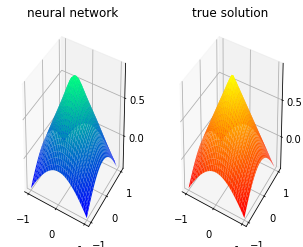

The running loss at 5009 iteration is: 0.00997806154191494
MSE between the true solution and NN sol: 4.121068e-05
The running loss at 5019 iteration is: 0.012201540172100067
MSE between the true solution and NN sol: 8.509029e-05
The running loss at 5029 iteration is: 0.01077477540820837
MSE between the true solution and NN sol: 5.947435e-05
The running loss at 5039 iteration is: 0.009507525712251663
MSE between the true solution and NN sol: 3.5071324e-05
The running loss at 5049 iteration is: 0.011331687681376934
MSE between the true solution and NN sol: 6.9143345e-05
The running loss at 5059 iteration is: 0.011629300191998482
MSE between the true solution and NN sol: 7.8975536e-05
The running loss at 5069 iteration is: 0.009862338192760944
MSE between the true solution and NN sol: 4.5336747e-05
The running loss at 5079 iteration is: 0.009802769869565964
MSE between the true solution and NN sol: 3.851876e-05
The running loss at 5089 iteration is: 0.012101506814360619
MSE between the tr

KeyboardInterrupt: ignored

In [10]:
torch.autograd.set_detect_anomaly(True)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
loss_mse = nn.MSELoss()

eps = 0.0001
iter = []
loss_array = []
##############################################
num_e = 12000 #3000#
for e in range(num_e):
    running_loss = 0
    optimizer.zero_grad() 
    coordinates = unpack_column(xs, ys, Nx, Ny)
    u_hat_array = model(coordinates).clone()  
    u_hat = pack_column(u_hat_array, Nx, Ny)


    # loss and backward
    u_star = 1-torch.sqrt(x**2 + y**2)
    loss = torch.mean((u_hat[ 0, :] - u_star[ 0, :])**2)
    loss += torch.mean((u_hat[-1, :] - u_star[-1, :])**2)
    loss += torch.mean((u_hat[ :, 0] - u_star[ :, 0])**2)
    loss += torch.mean((u_hat[ :,-1] - u_star[ :,-1])**2)

    u_hat[ 0, :] =  u_star[ 0, :]
    u_hat[-1, :] = u_star[-1, :]
    u_hat[ :, 0] = u_star[ :, 0]
    u_hat[ :,-1] = u_star[ :,-1]

    Delta_u = Laplacian(u_hat, step_x, step_y)
    one_tensor = torch.ones(Nx, Ny, dtype=torch.float32)
    [u_x, u_y] = gradient(u_hat, step_x, step_y)
    Du2 = u_x**2 + u_y**2
    loss += torch.mean((Du2[1:-1,1:-1] - eps*Delta_u[1:-1,1:-1] - one_tensor[1:-1, 1:-1]) **2)

    loss.backward()
    optimizer.step() 
    running_loss += loss.clone().item()   
    loss_array.append(running_loss)
    iter.append(e)
    if ((e+1) % 10 == 0):
        print(f"The running loss at {(e):03d} iteration is: {running_loss}")

        graph(x, y, u_hat)

        if (e+1)%500 == 0:
            plt.show()
        else:
            plt.close("all")